# Classification

In [1]:
import numpy as np
import pandas as pd
import bokeh, bokeh.plotting, bokeh.models, bokeh.io, bokeh.layouts
import sklearn.datasets
import ipywidgets
import dtreeviz

from sklearn.linear_model import RidgeClassifier, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import HTML, SVG

In [2]:
bokeh.io.output_file('./plots/classification/temp_bokeh.html')
colors = ['green', 'blue', 'red']
background_colors = [(208, 230, 208), (208, 208, 230), (230, 208, 208)]
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(9)
X_blobs, y_blobs = sklearn.datasets.make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=1)
X_circles, y_circles = sklearn.datasets.make_circles(n_samples=100)
X_moons, y_moons = sklearn.datasets.make_moons(n_samples=100)
X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

In [4]:
X_iris.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


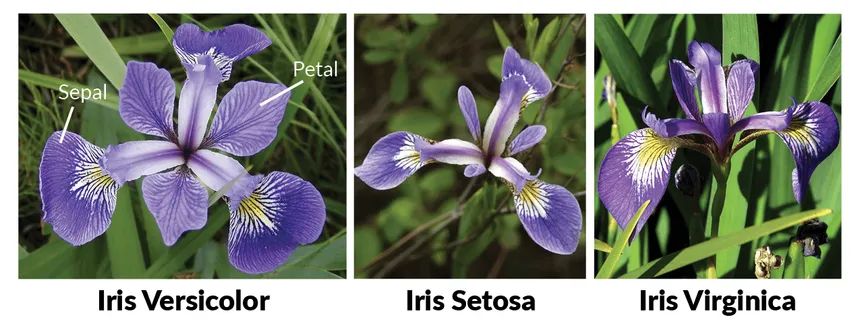

In [5]:
X_iris_sepal_only = np.asarray(X_iris[['sepal length (cm)', 'sepal width (cm)']])
Xs = [X_blobs, X_circles, X_moons, X_iris_sepal_only]
ys = [y_blobs, y_circles, y_moons, y_iris]

In [6]:
# some plotting functions

def create_empty_figure():
    return bokeh.plotting.figure(
        tools="pan,wheel_zoom,box_zoom,reset",
        width=400,
        height=300
    )


def show_dataset(X, y, figure=None):
    if figure is None:
        figure = create_empty_figure()
    figure.circle(X[:,0][y==0], X[:,1][y==0], size=10, color=colors[0])
    figure.circle(X[:,0][y==1], X[:,1][y==1], size=10, color=colors[1])
    if max(y) > 1:
        figure.circle(X[:,0][y==2], X[:,1][y==2], size=10, color=colors[2])
    figure.add_layout(bokeh.models.LinearAxis(), 'right')
    figure.add_layout(bokeh.models.LinearAxis(), 'above')
    return figure


def gridplot_datasets_in_bokeh(Xs, ys, titles=None):
    figures = []
    if titles is None:
        for X, y in zip(Xs, ys):
            figure = show_dataset(X, y)
            figures.append(figure)
    else:
        for (X, y), title in zip(zip(Xs, ys), titles):
            figure = show_dataset(X, y)
            figure.title.text = title
            figures.append(figure)

    gridplot = bokeh.layouts.gridplot([[figures[0], figures[1]], [figures[2], figures[3]]])
    return gridplot


def draw_trees_to_svg(model, X, y, feature_names, class_names, draw_tree_width):
    if type(model) == RandomForestClassifier:
        trees = model.estimators_
        if len(trees) > 10:
            trees = trees[:10]
    else:
        trees = [model]

    visplots = []
    for tree_index, tree in enumerate(trees):
        viz_model = dtreeviz.model(
            tree,
            X_train=X,
            y_train=y,
            feature_names=feature_names,
            target_name='' if len(trees) == 0 else f'Estimator {tree_index}',
            class_names=class_names
        )
        v = viz_model.view()
        v.save("./plots/classification/temp_dtreeviz.svg")
        visplot = open('./plots/classification/temp_dtreeviz.svg', 'r').read()
        visplot = visplot.replace('#fefebb', 'green')
        visplot = visplot.replace('#d9e6f5', 'blue')
        if max(y) == 2:
            visplot = visplot.replace('#a1dab4', 'red')
        else:
            visplot = visplot.replace('#a1dab4', 'blue')

        viewBox_index = visplot.find('viewBox')+9
        viewBox_info = visplot[viewBox_index:]
        viewBox_info = viewBox_info[:viewBox_info.find('"')]

        _, _, viewBox_width, viewBox_height = viewBox_info.split(' ')
        target_heigth = draw_tree_width*float(viewBox_height)/float(viewBox_width)
        visplot = visplot.replace(visplot[viewBox_index:viewBox_index+len(viewBox_info)], f'0 0 {draw_tree_width} {target_heigth}')

        scale = float(draw_tree_width) / float(viewBox_width)
        visplot = visplot.replace('scale(1.0 1.0)', f'scale({scale} {scale})')

        visplot_width_index = visplot.find('width=')+7
        visplot_width = visplot[visplot_width_index:]
        visplot_width = visplot_width[:visplot_width.find(' ')-1]
        visplot_heigth_index = visplot.find('height=')+8
        visplot_heigth = visplot[visplot_heigth_index:]
        visplot_heigth = visplot_heigth[:visplot_heigth.find(' ')-1]
        visplot = visplot.replace(visplot_width, str(draw_tree_width))
        visplot = visplot.replace(visplot_heigth, str(target_heigth))
        visplots.append(visplot)
    return visplots


def gridplot_predictions(Xs, ys, model, display_support_vectors, display_tree, draw_tree_width):
    figures = []
    svg_below = []
    for problem_index, (X, y) in enumerate(zip(Xs, ys)):
        figure = create_empty_figure()
        x1_span = max(X[:, 0])-min(X[:, 0])
        x1_range = np.arange(min(X[:, 0])-0.1*x1_span, max(X[:, 0])+0.1*x1_span, 0.04*x1_span)
        x2_span = max(X[:, 1])-min(X[:, 1])
        x2_range = np.arange(min(X[:, 1])-0.1*x2_span, max(X[:, 1])+0.1*x2_span, 0.04*x2_span)
        x1_range, x2_range = np.repeat(x1_range, x2_range.shape[0]), np.repeat(x2_range.reshape(1, -1), x1_range.shape[0], axis=0).flatten()

        model.fit(X, y)
        color = [background_colors[model.predict([[x1, x2]])[0]] for x1, x2 in zip(x1_range, x2_range)]
        figure.square(x1_range, x2_range, color=color, size=10)

        figure = show_dataset(X, y, figure)

        if display_support_vectors:
            support_vertices = [X[support_index] for support_index in model.support_]
            figure.circle([x[0] for x in support_vertices], [x[1] for x in support_vertices], size=10, color='black', fill_alpha=0.0, line_width=3)

        if display_tree == 'plot 4' and problem_index == 3:
            visplots = draw_trees_to_svg(
                model,
                X_iris[['sepal length (cm)', 'sepal width (cm)']],
                y_iris, ['sepal length (cm)', 'sepal width (cm)'],
                ['Versicolor', 'Setosa', 'Virginica'],
                draw_tree_width
            )
            svg_below.extend(visplots)
        elif display_tree in ['plot 1', 'plot 2', 'plot 3'] and problem_index == int(display_tree[-1]) - 1:
            class_names = ['class 1', 'class 2', 'class 3'] if max(y) == 2 else ['class 1', 'class 2']
            visplots = draw_trees_to_svg(model, pd.DataFrame(X, columns=['x1', 'x2']), y, ['x1', 'x2'], class_names, draw_tree_width)
            svg_below.extend(visplots)

        figures.append(figure)
    gridplot = bokeh.layouts.gridplot([[figures[0], figures[1]], [figures[2], figures[3]]])
    return gridplot, svg_below

In [7]:
gridplot = gridplot_datasets_in_bokeh(Xs, ys)
_ = bokeh.plotting.save(gridplot)
gridplot = open('./plots/classification/temp_bokeh.html', 'r').read()
display(HTML(gridplot))

In [8]:
X, y = Xs[0], ys[0]
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
print(model.predict(X[0:3]))

[1 0 2]


In [ ]:
# a big plotting code


def create_interactive_menu():
    interactive_menu = {}
    interactive_menu['alpha'] = ipywidgets.FloatSlider(min=0.0, max=10.0, step=0.5, description="λ", continuous_update=False)
    interactive_menu['kernel'] = ipywidgets.ToggleButtons(options=['linear', 'poly', 'rbf', 'sigmoid'], description="kernel")
    interactive_menu['max_depth'] = ipywidgets.IntSlider(min=1, max=10, step=1, description="max depth", continuous_update=False)
    interactive_menu['ccp_alpha'] = ipywidgets.FloatSlider(min=0.0, max=0.1, step=0.01, description="pruning str", continuous_update=False)
    interactive_menu['n_neighbors'] = ipywidgets.IntSlider(min=1, max=30, step=1, description="neighbours", continuous_update=False)
    interactive_menu['weights'] = ipywidgets.ToggleButtons(options=['uniform', 'distance'], description="weights", continuous_update=False)
    interactive_menu['max_iter'] = ipywidgets.FloatLogSlider(value=1000, base=10, min=1, max=4, step=1, description="max_iter", continuous_update=False)
    interactive_menu['activation'] = ipywidgets.ToggleButtons(options=['identity', 'logistic', 'tanh', 'relu'], description="activation function")
    interactive_menu['num_h_layers'] = ipywidgets.IntSlider(value=2, min=1, max=4, step=1, description="num_h_layers", continuous_update=False)
    interactive_menu['size_h_layers'] = ipywidgets.FloatLogSlider(value=10, base=10, min=0, max=3, step=1, description="size_h_layers", continuous_update=False)
    interactive_menu['n_estimators'] = ipywidgets.IntSlider(min=1, max=30, step=1, description="estimators", continuous_update=False)
    interactive_menu['max_depth_rf'] = ipywidgets.IntSlider(min=1, max=10, step=1, description="max depth", continuous_update=False)
    interactive_menu['support_vectors'] = ipywidgets.ToggleButton(value=False, description="show support vertors")
    interactive_menu['draw_tree'] = ipywidgets.ToggleButtons(
        value='don\'t plot',
        options=['plot 1', 'plot 2', 'plot 3', 'plot 4', 'don\'t plot'],
        style={'button_width':'100px'},
        description="",
        layout=ipywidgets.Layout(display='flex', align_items='flex-end', width='290px')
    )
    interactive_menu['draw_tree_width'] = ipywidgets.IntSlider(value=500, min=200, max=1000, step=50, description="plot width", continuous_update=False)
    interactive_menu['draw_tree_rf'] = ipywidgets.ToggleButtons(
        value='don\'t plot',
        options=['plot 1', 'plot 2', 'plot 3', 'plot 4', 'don\'t plot'],
        style={'button_width':'100px'},
        description="",
        layout=ipywidgets.Layout(display='flex', align_items='flex-end', width='290px')
    )
    interactive_menu['draw_tree_width_rf'] = ipywidgets.IntSlider(value=500, min=200, max=1000, step=50, description="plot width", continuous_update=False)

    for interactive_component in interactive_menu.values():
        interactive_component.observe(render_widgets, names='value')

    tabRidge = ipywidgets.VBox(children=[interactive_menu['alpha']])
    tabSVM = ipywidgets.HBox(children=[ipywidgets.VBox(children=[interactive_menu['kernel']], layout=ipywidgets.Layout(width='1000px')), ipywidgets.VBox(children=[interactive_menu['support_vectors']])])
    tabDecisionTree = ipywidgets.HBox(children=[
        ipywidgets.VBox(children=[interactive_menu['max_depth'], interactive_menu['ccp_alpha']], layout=ipywidgets.Layout(width='600px')),
        ipywidgets.VBox(children=[interactive_menu['draw_tree'], interactive_menu['draw_tree_width']])
    ])
    tabkNN = ipywidgets.VBox(children=[interactive_menu['n_neighbors'], interactive_menu['weights']])
    tabPerceptron = ipywidgets.VBox(children=[interactive_menu['max_iter']])
    tabMLP = ipywidgets.VBox(children=[interactive_menu['activation'], interactive_menu['num_h_layers'], interactive_menu['size_h_layers']])
    tabRandomForest = ipywidgets.HBox(children=[
        ipywidgets.VBox(children=[interactive_menu['n_estimators'], interactive_menu['max_depth_rf']], layout=ipywidgets.Layout(width='600px')),
        ipywidgets.VBox(children=[interactive_menu['draw_tree_rf'], interactive_menu['draw_tree_width_rf']])
    ])
    tab = ipywidgets.Tab(children=[tabRidge, tabSVM, tabDecisionTree, tabkNN, tabPerceptron, tabMLP, tabRandomForest])
    tab.set_title(0, 'Ridge Classifier')
    tab.set_title(1, 'SVM')
    tab.set_title(2, 'Decision tree')
    tab.set_title(3, 'kNN')
    tab.set_title(4, 'Perceptron')
    tab.set_title(5, 'MLP')
    tab.set_title(6, 'Random Forest')
    return interactive_menu, tab


def get_component_which_value_changed(prev_values, interactive_menu):
    for k, v in prev_values.items():
        if v != interactive_menu[k].value:
            return k
    raise Exception('render_widgets was called despite no component change')


def select_model_depending_on_widget_changes(prev_values, interactive_menu):
    display_support_vectors = False
    display_tree = False
    draw_tree_width = 0
    if len(prev_values) == 0:
        model = RidgeClassifier(alpha=interactive_menu['alpha'].value)
        return model, display_support_vectors, display_tree, draw_tree_width

    changed_key = get_component_which_value_changed(prev_values, interactive_menu)

    if changed_key == 'alpha':
        model = RidgeClassifier(alpha=interactive_menu['alpha'].value)
    elif changed_key in ['kernel', 'support_vectors']:
        model = SVC(kernel=interactive_menu['kernel'].value)
        display_support_vectors = interactive_menu['support_vectors'].value
    elif changed_key in ['max_depth', 'ccp_alpha', 'draw_tree', 'draw_tree_width']:
        model = DecisionTreeClassifier(
            max_depth=interactive_menu['max_depth'].value,
            ccp_alpha=interactive_menu['ccp_alpha'].value
        )
        display_tree = interactive_menu['draw_tree'].value
        draw_tree_width = interactive_menu['draw_tree_width'].value
    elif changed_key in ['n_neighbors', 'weights']:
        model = KNeighborsClassifier(
            n_neighbors=interactive_menu['n_neighbors'].value,
            weights=interactive_menu['weights'].value
        )
    elif changed_key == 'max_iter':
        model = Perceptron(tol=None, max_iter=int(interactive_menu['max_iter'].value))
    elif changed_key in ['activation', 'size_h_layers', 'num_h_layers']:
        model = MLPClassifier(
            activation=interactive_menu['activation'].value,
            hidden_layer_sizes=([
                int(interactive_menu['size_h_layers'].value)
                for _ in range(int(interactive_menu['num_h_layers'].value))
            ])
        )
    elif changed_key in ['n_estimators', 'max_depth_rf', 'draw_tree_rf']:
        model = RandomForestClassifier(
            n_estimators=interactive_menu['n_estimators'].value,
            max_depth=interactive_menu['max_depth_rf'].value
        )
        display_tree = interactive_menu['draw_tree_rf'].value
        draw_tree_width = interactive_menu['draw_tree_width_rf'].value

    return model, display_support_vectors, display_tree, draw_tree_width


prev_values = {}
out = ipywidgets.Output()

@out.capture(clear_output=True, wait=True)
def render_widgets(change):
    model, display_support_vectors, display_tree, draw_tree_width = select_model_depending_on_widget_changes(
        prev_values, interactive_menu
    )
    gridplot, svg_below = gridplot_predictions(
        Xs,
        ys,
        model,
        display_support_vectors=display_support_vectors,
        display_tree=display_tree,
        draw_tree_width=draw_tree_width
    )
    bokeh.plotting.save(gridplot)
    gridplot = open('./plots/classification/temp_bokeh.html', 'r').read()

    display(HTML(gridplot))
    for svg_plot in svg_below:
        display(SVG(svg_plot))
    for k in interactive_menu.keys():
        prev_values[k] = interactive_menu[k].value


interactive_menu, tab = create_interactive_menu()

render_widgets(None)
display(ipywidgets.VBox([tab, out]))

In [10]:
X_iris_petal_only = np.asarray(X_iris[['petal length (cm)', 'petal width (cm)']])
X_iris_length_only = np.asarray(X_iris[['sepal length (cm)', 'petal length (cm)']])
X_iris_pca = PCA(n_components=2).fit_transform(X_iris)

Xs_iris_reductions = [X_iris_sepal_only, X_iris_petal_only, X_iris_length_only, X_iris_pca]
ys_iris_reducitons = [y_iris for _ in range(4)]
titles = ['Sepal only', 'Petal only', 'Length only', 'PCA']

gridplot = gridplot_datasets_in_bokeh(Xs_iris_reductions, ys_iris_reducitons, titles)
_ = bokeh.plotting.save(gridplot)
gridplot = open('./plots/classification/temp_bokeh.html', 'r').read()
display(HTML(gridplot))